In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
Data=pd.read_csv('Data.csv',names = ['Del_V','V','Del_T','SOH'])    #Data of battery 1
Data1=pd.read_csv('Data1.csv',names = ['Del_V','V','Del_T','SOH'])  #Data of battery 2
Data2=pd.read_csv('Data2.csv',names = ['Del_V','V','Del_T','SOH'])  #Data of battery 3
Data3=pd.read_csv('Data3.csv',names = ['Del_V','V','Del_T','SOH'])  #Data of battery 4
D=pd.concat([Data,Data1,Data2,Data3])

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
x=normalize(D[['Del_V','V','Del_T']])  # Normalizing the input
y=np.array(D.SOH).reshape(len(D),1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05)  # Splitting the data into train and test data
data = {'x_train': x_train,   # Naming the data after being splitted
            'x_test': x_test, 
            'y_train': y_train, 
            'y_test': y_test}

In [37]:
# Calculating probability density function for each classification as given in the paper
def pdf(centre, x, sigma):
    temp = -np.sum((centre - x) ** 2, axis = 1)  
    #print(temp.shape)
    temp = temp / (2 * sigma * sigma)
    temp = np.exp(temp)
    return temp

# Splitting the training set into subsets where each subset contains data points from a particular class
def subset_by_class(data, labels):

    x_train_subsets = []

    for l in labels:
        indices = np.where(data['y_train'] == l)
        x_train_subsets.append(data['x_train'][indices, :])

    return x_train_subsets


def PNN(data):

    num_testset = data['x_test'].shape[0]
    labels = np.unique(data['y_train'])
    num_class = len(labels)

    sigma = 0.1 # Smoothing parameter 

    x_train_subsets = subset_by_class(data, labels) # Splitting the training set into subsets where each subset contains data points from a particular class
    #print(x_train_subsets)

    summation_layer = np.zeros(num_class) # Variable for storing the summation layer values from each class
    
    predictions = np.zeros(num_testset) # Variable for storing the predictions for each test data point

    for i, test_point in enumerate(data['x_test']):

        for j, subset in enumerate(x_train_subsets):
            W = np.random.dirichlet(np.ones(1),size=1) # Declaring the weights with the total sum being equal to 1
            test_point=test_point.reshape(1,3)
            summation_layer[j] = np.sum(pdf(test_point, subset[0], sigma) ) / subset[0].shape[0]   # Calculate summation layer
            #print(summation_layer[j])
            #print(pdf(test_point, subset[0], sigma))
            #print(test_point.shape)
            #print(subset[0].shape)
        
        predictions[i] = labels[(np.argmax(summation_layer))] # The index having the largest value in the summation layer is chosen

    return predictions

## PNN

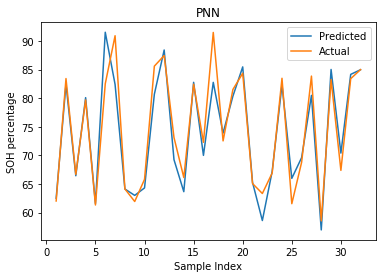

0.005467384062500001

In [46]:
#Plotting
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),PNN(data).reshape(32,1)/2.2*100)
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),y_test.reshape(32,1)/2.2*100)
plt.xlabel('Sample Index')
plt.ylabel('SOH percentage')
plt.legend(['Predicted','Actual'])
plt.title('PNN')
plt.show()
print('Error: ',np.mean((((PNN(data).reshape(32,1)-y_test)**2))))

## KNN

In [49]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

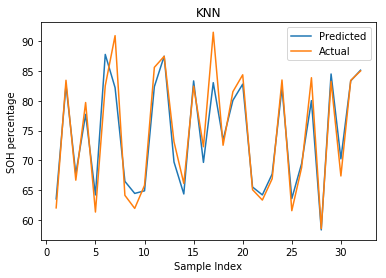

Error:  0.0041568161458333365


In [58]:
#Plotting
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),neigh.predict(x_test).reshape(32,1)/2.2*100)
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),y_test.reshape(32,1)/2.2*100)
plt.xlabel('Sample Index')
plt.ylabel('SOH percentage')
plt.legend(['Predicted','Actual'])
plt.title('KNN')
plt.show()
print('Error: ',np.mean((((neigh.predict(x_test)-y_test)**2))))

## SVM

In [55]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
regr = make_pipeline(StandardScaler(), SVR(C=35, epsilon=0.01))
regr.fit(x_train,y_train)

C:\Users\Aditya\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=35, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

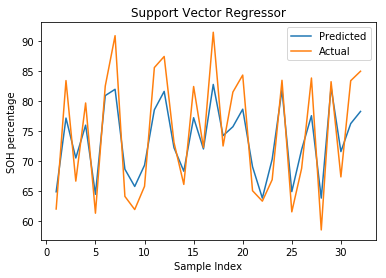

Error:  0.06725850732624067


In [59]:
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),regr.predict(x_test).reshape(32,1)/2.2*100)
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),y_test.reshape(32,1)/2.2*100)
plt.xlabel('Sample Index')
plt.ylabel('SOH percentage')
plt.legend(['Predicted','Actual'])
plt.title('Support Vector Regressor')
plt.show()
print('Error: ',np.mean((((regr.predict(x_test)-y_test)**2))))

## Comparison

[]

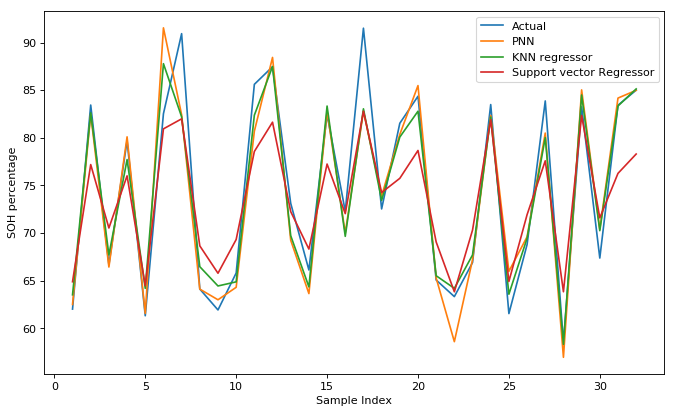

In [60]:
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),y_test.reshape(32,1)/2.2*100)
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),PNN(data).reshape(32,1)/2.2*100)
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),neigh.predict(x_test).reshape(32,1)/2.2*100)
plt.plot(np.linspace(1,32,num=32,axis=0).reshape(-1,1),regr.predict(x_test).reshape(32,1)/2.2*100)
plt.xlabel('Sample Index')
plt.ylabel('SOH percentage')
plt.legend(['Actual','PNN','KNN regressor','Support vector Regressor'])
plt.plot()